In [1]:
import pandas as pd
import numpy as np
import time
import math

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB

from sklearn import svm

from sklearn.metrics import confusion_matrix

from datetime import datetime
from dateutil import relativedelta as rdelta
from datetime import date

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
#reading file
full_data = pd.read_csv('data/loan_ss_2007_2011.csv')

In [4]:
full_data.shape

(39318, 51)

In [5]:
full_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'desc', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'total_acc', 'revol_bal', 'revol_util', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'mths_since_rcnt_il',
       'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'chargeoff_within_12_mths', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'fico_range_high', 'fico_range_low',
       'loan_status'],
      dtype='object')

In [6]:
full_data.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_range_high,fico_range_low,loan_status
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,739.0,735.0,Fully Paid
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,744.0,740.0,Charged Off


In [7]:
#dataframe to store feature engineered fields
feat_engg_df = pd.DataFrame()

#deleted fields list
del_fields = []

#### Feature : Term

In [8]:
term_unq = list(full_data['term'].unique())
print(term_unq)

[' 36 months', ' 60 months']


In [9]:
#converting term into binary columns
term_df = pd.get_dummies(pd.DataFrame(full_data['term']))
term_df = term_df.applymap(int)
term_df.head()

,term_ 36 months,term_ 60 months
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [10]:
feat_engg_df = pd.concat([feat_engg_df,term_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [11]:
del_fields.append('term')
del_fields

['term']

#### Feature : Employment Length

In [12]:

emp_dict = {'n/a':-1,
 '< 1 year' : 0,
 '1 year' : 1,
 '2 years' : 2,
 '3 years' : 3,
 '4 years' : 4,
 '5 years' : 5,
 '6 years' : 6,
 '7 years' : 7,
 '8 years' : 8,
 '9 years' : 9,
 '10+ years' : 10,
}

emp_dict

{'1 year': 1,
 '10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '4 years': 4,
 '5 years': 5,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9,
 '< 1 year': 0,
 'n/a': -1}

In [13]:
emp_df = full_data['emp_length'].replace(emp_dict)
np.unique(emp_df)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
feat_engg_df = pd.concat([feat_engg_df,emp_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length
0,1,0,10
1,0,1,0
2,1,0,10
3,1,0,10
4,1,0,3


In [15]:
del_fields.append('emp_length')
del_fields

['term', 'emp_length']

#### Feature : Interest Rate

In [16]:
int_df = full_data['int_rate'].apply(lambda s : float(s[:-1]))
int_df.head()

0    10.65
1    15.27
2    15.96
3    13.49
4     7.90
Name: int_rate, dtype: float64

In [17]:
feat_engg_df = pd.concat([feat_engg_df,int_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate
0,1,0,10,10.65
1,0,1,0,15.27
2,1,0,10,15.96
3,1,0,10,13.49
4,1,0,3,7.90


In [18]:
del_fields.append('int_rate')
del_fields

['term', 'emp_length', 'int_rate']

#### Feature : verification_status

In [19]:
veri_unq = list(full_data['verification_status'].unique())
print(veri_unq)

['Verified', 'Source Verified', 'Not Verified']


In [20]:
#converting term into binary columns
veri_df = pd.get_dummies(pd.DataFrame(full_data['verification_status']))
veri_df = veri_df.applymap(int)
veri_df.head()

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0,0,1
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


In [21]:
feat_engg_df = pd.concat([feat_engg_df,veri_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,1,0,10,10.65,0,0,1
1,0,1,0,15.27,0,1,0
2,1,0,10,15.96,1,0,0
3,1,0,10,13.49,0,1,0
4,1,0,3,7.90,0,1,0


In [22]:
del_fields.append('verification_status')
del_fields

['term', 'emp_length', 'int_rate', 'verification_status']

#### Feature : purpose

In [23]:
purp_unq = list(full_data['purpose'].unique())
print(purp_unq)

['credit_card', 'car', 'small_business', 'other', 'wedding', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'moving', 'vacation', 'house', 'renewable_energy', 'educational']


In [24]:
#converting term into binary columns
purp_df = pd.get_dummies(pd.DataFrame(full_data['purpose']))
purp_df = purp_df.applymap(int)
purp_df.head()

,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
feat_engg_df = pd.concat([feat_engg_df,purp_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,10,13.49,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
del_fields.append('purpose')
del_fields

['term', 'emp_length', 'int_rate', 'verification_status', 'purpose']

#### Feature : Earliest Credit Line

In [27]:
full_data['earliest_cr_line'].unique()
ear_cl_df = full_data['earliest_cr_line'].apply(lambda s : datetime.strptime(s,'%b-%y'))
ear_cl_df.head()

0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
4   2004-11-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [28]:
yr_diff = [ rdelta.relativedelta(date(2012,1,1),pd.Timestamp(i).to_pydatetime()).years for i in ear_cl_df.values] 

In [29]:
ear_cl_df = pd.DataFrame(yr_diff)
ear_cl_df.columns = ['years_since_first_credit']

In [30]:
ear_cl_df.head()

,years_since_first_credit
0,27
1,12
2,10
3,15
4,7


In [31]:
feat_engg_df = pd.concat([feat_engg_df,ear_cl_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,27
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,12
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10
3,1,0,10,13.49,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,15
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7


In [32]:
del_fields.append('earliest_cr_line')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line']

#### Feature : Months since last delinq

In [33]:
last_delinq_unq = list(full_data['mths_since_last_delinq'].unique())
print(last_delinq_unq)

[nan, 35.0, 61.0, 8.0, 20.0, 18.0, 45.0, 38.0, 48.0, 41.0, 40.0, 74.0, 25.0, 53.0, 39.0, 10.0, 26.0, 77.0, 28.0, 56.0, 52.0, 24.0, 16.0, 60.0, 54.0, 23.0, 9.0, 11.0, 13.0, 65.0, 19.0, 80.0, 22.0, 59.0, 79.0, 44.0, 57.0, 14.0, 63.0, 49.0, 15.0, 73.0, 70.0, 29.0, 51.0, 5.0, 75.0, 55.0, 2.0, 30.0, 47.0, 69.0, 4.0, 43.0, 33.0, 21.0, 27.0, 46.0, 81.0, 68.0, 78.0, 82.0, 31.0, 64.0, 76.0, 62.0, 72.0, 42.0, 50.0, 3.0, 12.0, 34.0, 58.0, 17.0, 71.0, 66.0, 32.0, 6.0, 36.0, 37.0, 7.0, 67.0, 1.0, 83.0, 86.0, 115.0, 96.0, 103.0, 120.0, 106.0, 89.0, 107.0, 85.0, 97.0, 95.0, 0.0]


In [34]:
#converting term into binary columns
#nan implies never delinquent
last_delinq_df = full_data['mths_since_last_delinq'].apply(lambda s : int(~np.isnan(s)))
last_delinq_df.name = 'has_delinquent_hist'
last_delinq_df.head()

0    0
1    0
2    0
3    1
4    0
Name: has_delinquent_hist, dtype: int64

In [35]:
#about 35% has delinquency history
np.mean(last_delinq_df)

0.3537819828068569

In [36]:
feat_engg_df = pd.concat([feat_engg_df,last_delinq_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,27,0
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,12,0
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,0
3,1,0,10,13.49,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,15,1
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,7,0


In [37]:
del_fields.append('mths_since_last_delinq')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'mths_since_last_delinq']

#### Feature : Months since last record

In [38]:
last_record_unq = list(full_data['mths_since_last_record'].unique())
print(last_record_unq)

[nan, 113.0, 105.0, 97.0, 33.0, 93.0, 52.0, 85.0, 90.0, 91.0, 114.0, 92.0, 117.0, 87.0, 45.0, 83.0, 118.0, 38.0, 101.0, 100.0, 112.0, 110.0, 88.0, 79.0, 77.0, 107.0, 102.0, 98.0, 95.0, 96.0, 116.0, 103.0, 111.0, 89.0, 108.0, 29.0, 106.0, 115.0, 53.0, 86.0, 57.0, 63.0, 94.0, 99.0, 104.0, 76.0, 61.0, 28.0, 109.0, 23.0, 75.0, 47.0, 82.0, 21.0, 62.0, 44.0, 80.0, 67.0, 119.0, 42.0, 34.0, 66.0, 58.0, 22.0, 56.0, 72.0, 64.0, 50.0, 69.0, 49.0, 74.0, 35.0, 12.0, 26.0, 78.0, 54.0, 37.0, 73.0, 11.0, 31.0, 59.0, 32.0, 81.0, 68.0, 55.0, 39.0, 51.0, 70.0, 30.0, 41.0, 71.0, 40.0, 43.0, 27.0, 65.0, 46.0, 19.0, 17.0, 25.0, 13.0, 48.0, 36.0, 7.0, 60.0, 14.0, 6.0, 18.0, 0.0, 20.0, 120.0, 129.0, 5.0]


In [39]:
#converting term into binary columns
#nan implies never had record
last_record_df = full_data['mths_since_last_record'].apply(lambda s : int(~np.isnan(s)))
last_record_df.name = 'has_record_hist'
last_record_df.head()

0    0
1    0
2    0
3    0
4    0
Name: has_record_hist, dtype: int64

In [40]:
#about 7% has delinquency history
np.mean(last_record_df)

0.07068009563050003

In [41]:
feat_engg_df = pd.concat([feat_engg_df,last_record_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,0,0,27,0,0
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,0,0,12,0,0
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,0,0,1,0,0,10,0,0
3,1,0,10,13.49,0,1,0,0,0,0,...,0,0,1,0,0,0,0,15,1,0
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,0,0,1,7,0,0


In [42]:
del_fields.append('mths_since_last_record')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record']

#### Feature : Total Hi Credit Lim

In [43]:
#completely null, removing column
hi_credli_unq = list(full_data['tot_hi_cred_lim'].unique())
print(hi_credli_unq)

[nan]


#### Feature : Total balance ex Mortgage

In [44]:
total_bal_unq = list(full_data['total_bal_ex_mort'].unique())
print(total_bal_unq)

[nan]


#### Feature : Total bankcard high credit limit

In [45]:
total_bankc_hl_unq = list(full_data['total_bc_limit'].unique())
print(total_bankc_hl_unq)

[nan]


#### Feature : Total installment high credit limit

In [46]:
total_inst_hl_unq = list(full_data['total_il_high_credit_limit'].unique())
print(total_inst_hl_unq)

[nan]


#### Feature : % trades never delinquent

In [47]:
per_trade_ndelq_unq = list(full_data['pct_tl_nvr_dlq'].unique())
print(per_trade_ndelq_unq)

[nan]


#### Feature : % bankcard > 75

In [48]:
per_bankc_75_unq = list(full_data['percent_bc_gt_75'].unique())
print(per_bankc_75_unq)

[nan]


#### Feature : Open to buy on revolving bankcards

In [49]:
open_buy_bc_unq = list(full_data['bc_open_to_buy'].unique())
print(open_buy_bc_unq)

[nan]


In [50]:
list(full_data['bc_util'].unique())


[nan]

In [51]:
list(full_data['inq_fi'].unique())

[nan]

In [52]:
list(full_data['avg_cur_bal'].unique())

[nan]

In [53]:
list(full_data['max_bal_bc'].unique())

[nan]

In [54]:
list(full_data['all_util'].unique())

[nan]

In [55]:
list(full_data['total_rev_hi_lim'].unique())

[nan]

In [56]:
list(full_data['tot_coll_amt'].unique())

[nan]

In [57]:
list(full_data['tot_cur_bal'].unique())

[nan]

In [58]:
list(full_data['mths_since_rcnt_il'].unique())

[nan]

In [59]:

list(full_data['mths_since_last_major_derog'].unique())

[nan]

In [60]:

list(full_data['chargeoff_within_12_mths'].unique())

[0.0, nan]

In [61]:
list(full_data['tax_liens'].unique())


[0.0, nan]

#### Feature : credit_utilization

In [62]:
t_list = []
for val in full_data['revol_util'].values:
    if str(val)=='nan':
        t_list.append(100)
    else:
        t_list.append(float(val[:-1]))




In [63]:
credit_util_df = pd.DataFrame(t_list)
credit_util_df.columns = ['revol_util']

In [64]:
feat_engg_df = pd.concat([feat_engg_df,credit_util_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,0,27,0,0,83.7
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,0,12,0,0,9.4
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,0,1,0,0,10,0,0,98.5
3,1,0,10,13.49,0,1,0,0,0,0,...,0,1,0,0,0,0,15,1,0,21.0
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,0,1,7,0,0,28.3


In [65]:
del_fields.append('revol_util')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util']

#### Feature : Bankruptcies

In [66]:
b_list = []
for val in full_data['pub_rec_bankruptcies'].values:
    if str(val)=='nan' or val==0:
        b_list.append(0)
    else:
        b_list.append(val)



In [67]:
np.unique(b_list)

array([ 0.,  1.,  2.])

In [68]:
bankrupt_df = pd.DataFrame(b_list)
bankrupt_df.columns = ['bankruptcies']

In [69]:
feat_engg_df = pd.concat([feat_engg_df,bankrupt_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,0,27,0,0,83.7,0.0
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,0,12,0,0,9.4,0.0
2,1,0,10,15.96,1,0,0,0,0,0,...,0,0,1,0,0,10,0,0,98.5,0.0
3,1,0,10,13.49,0,1,0,0,0,0,...,1,0,0,0,0,15,1,0,21.0,0.0
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,0,1,7,0,0,28.3,0.0


In [70]:
del_fields.append('pub_rec_bankruptcies')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'pub_rec_bankruptcies']

#### Feature : Fico

In [71]:
fico_df = full_data.loc[:,['fico_range_low','fico_range_high']]

In [72]:
fico_df['avg_fico'] = (fico_df.fico_range_low + fico_df.fico_range_high)/2

In [73]:
fico_df = fico_df.drop(['fico_range_low','fico_range_high'],axis=1)

In [74]:
fico_df.head()

,avg_fico
0,737.0
1,742.0
2,737.0
3,692.0
4,732.0


In [75]:
feat_engg_df = pd.concat([feat_engg_df,fico_df],axis=1)
feat_engg_df.head()

,term_ 36 months,term_ 60 months,emp_length,int_rate,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies,avg_fico
0,1,0,10,10.65,0,0,1,0,1,0,...,0,0,0,0,27,0,0,83.7,0.0,737.0
1,0,1,0,15.27,0,1,0,1,0,0,...,0,0,0,0,12,0,0,9.4,0.0,742.0
2,1,0,10,15.96,1,0,0,0,0,0,...,0,1,0,0,10,0,0,98.5,0.0,737.0
3,1,0,10,13.49,0,1,0,0,0,0,...,0,0,0,0,15,1,0,21.0,0.0,692.0
4,1,0,3,7.90,0,1,0,0,0,0,...,0,0,0,1,7,0,0,28.3,0.0,732.0


In [76]:
del_fields.append('fico_range_low')
del_fields.append('fico_range_high')
del_fields

['term',
 'emp_length',
 'int_rate',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'pub_rec_bankruptcies',
 'fico_range_low',
 'fico_range_high']

In [77]:
#deleting unwanted columns
#del full_data['addr_state']
del full_data['desc']
del full_data['grade']
del full_data['sub_grade']

#fully null
del full_data['tot_hi_cred_lim']
del full_data['total_bal_ex_mort']
del full_data['total_bc_limit']
del full_data['total_il_high_credit_limit']
del full_data['pct_tl_nvr_dlq']
del full_data['percent_bc_gt_75']
del full_data['bc_open_to_buy']
del full_data['bc_util']
del full_data['inq_fi']
del full_data['acc_open_past_24mths']
del full_data['avg_cur_bal']
del full_data['max_bal_bc']
del full_data['all_util']
del full_data['total_rev_hi_lim']
del full_data['tot_coll_amt']
del full_data['tot_cur_bal']
del full_data['mths_since_rcnt_il']
del full_data['mths_since_last_major_derog']
del full_data['chargeoff_within_12_mths']
del full_data['pub_rec_bankruptcies']
del full_data['tax_liens']

#feature engineered
del full_data['term']
del full_data['int_rate']
del full_data['emp_length']
del full_data['verification_status']
del full_data['purpose']
del full_data['earliest_cr_line']
del full_data['mths_since_last_delinq']
del full_data['mths_since_last_record']
del full_data['revol_util']
del full_data['fico_range_low']
del full_data['fico_range_high']



In [78]:
#copying data
as_is_data = full_data.copy()

In [79]:
as_is_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'home_ownership', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'total_acc', 'revol_bal', 'acc_now_delinq', 'il_util',
       'inq_last_12m', 'loan_status'],
      dtype='object')

In [80]:
list(full_data['il_util'].unique())

[nan]

In [81]:
del as_is_data['il_util']

In [82]:
list(full_data['inq_last_12m'].unique())

[nan]

In [83]:
del as_is_data['inq_last_12m']

In [84]:
list(full_data['acc_now_delinq'].unique())

[0.0]

In [85]:
del as_is_data['acc_now_delinq']

#### Feature : % of Open Accounts

In [86]:
as_is_data['per_act_open'] = as_is_data.open_acc/as_is_data.total_acc

In [87]:
as_is_data['per_act_open'].head()

0    0.333333
1    0.750000
2    0.200000
3    0.270270
4    0.750000
Name: per_act_open, dtype: float64

In [88]:
del as_is_data['open_acc']
del as_is_data['total_acc']

In [89]:
data = pd.concat([as_is_data,feat_engg_df],axis=1)
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,home_ownership,annual_inc,dti,delinq_2yrs,inq_last_6mths,revol_bal,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies,avg_fico
0,5000.0,5000.0,4975.0,162.87,RENT,24000.0,27.65,0.0,1.0,13648.0,...,0,0,0,0,27,0,0,83.7,0.0,737.0
1,2500.0,2500.0,2500.0,59.83,RENT,30000.0,1.00,0.0,5.0,1687.0,...,0,0,0,0,12,0,0,9.4,0.0,742.0
2,2400.0,2400.0,2400.0,84.33,RENT,12252.0,8.72,0.0,2.0,2956.0,...,0,1,0,0,10,0,0,98.5,0.0,737.0
3,10000.0,10000.0,10000.0,339.31,RENT,49200.0,20.00,0.0,1.0,5598.0,...,0,0,0,0,15,1,0,21.0,0.0,692.0
4,5000.0,5000.0,5000.0,156.46,RENT,36000.0,11.20,0.0,3.0,7963.0,...,0,0,0,1,7,0,0,28.3,0.0,732.0


In [90]:
#del data['loan_amnt']
del data['funded_amnt']
#del data['funded_amnt_inv']
del data['annual_inc']
del data['installment']

In [91]:
data.head()

,loan_amnt,funded_amnt_inv,home_ownership,dti,delinq_2yrs,inq_last_6mths,revol_bal,loan_status,per_act_open,term_ 36 months,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies,avg_fico
0,5000.0,4975.0,RENT,27.65,0.0,1.0,13648.0,Fully Paid,0.333333,1,...,0,0,0,0,27,0,0,83.7,0.0,737.0
1,2500.0,2500.0,RENT,1.00,0.0,5.0,1687.0,Charged Off,0.750000,0,...,0,0,0,0,12,0,0,9.4,0.0,742.0
2,2400.0,2400.0,RENT,8.72,0.0,2.0,2956.0,Fully Paid,0.200000,1,...,0,1,0,0,10,0,0,98.5,0.0,737.0
3,10000.0,10000.0,RENT,20.00,0.0,1.0,5598.0,Fully Paid,0.270270,1,...,0,0,0,0,15,1,0,21.0,0.0,692.0
4,5000.0,5000.0,RENT,11.20,0.0,3.0,7963.0,Fully Paid,0.750000,1,...,0,0,0,1,7,0,0,28.3,0.0,732.0


In [92]:
ownership_lookup = { own : i for i,own in enumerate(full_data.home_ownership.unique())}
ownership_lookup

{'MORTGAGE': 2, 'NONE': 4, 'OTHER': 3, 'OWN': 1, 'RENT': 0}

In [93]:
data['home_ownership'].replace(ownership_lookup, inplace=True)

In [94]:
data.head(2)

,loan_amnt,funded_amnt_inv,home_ownership,dti,delinq_2yrs,inq_last_6mths,revol_bal,loan_status,per_act_open,term_ 36 months,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies,avg_fico
0,5000.0,4975.0,0,27.65,0.0,1.0,13648.0,Fully Paid,0.333333,1,...,0,0,0,0,27,0,0,83.7,0.0,737.0
1,2500.0,2500.0,0,1.00,0.0,5.0,1687.0,Charged Off,0.750000,0,...,0,0,0,0,12,0,0,9.4,0.0,742.0


In [95]:
loan_status_lookup = { own : i for i,own in enumerate(full_data.loan_status.unique())}
loan_status_lookup

{'Charged Off': 1, 'Fully Paid': 0}

In [96]:
data['loan_status'].replace(loan_status_lookup, inplace=True)

In [97]:
data.head(2)

,loan_amnt,funded_amnt_inv,home_ownership,dti,delinq_2yrs,inq_last_6mths,revol_bal,loan_status,per_act_open,term_ 36 months,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies,avg_fico
0,5000.0,4975.0,0,27.65,0.0,1.0,13648.0,0,0.333333,1,...,0,0,0,0,27,0,0,83.7,0.0,737.0
1,2500.0,2500.0,0,1.00,0.0,5.0,1687.0,1,0.750000,0,...,0,0,0,0,12,0,0,9.4,0.0,742.0


In [369]:
#writing csv
data.to_csv('data/loan_fteng_data.csv',index=False)

In [98]:
y = data['loan_status']
x = data.copy()
del x['loan_status']

#### Eliminate Features with Multicollinearity

In [99]:
#http://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X):

    '''X - pandas dataframe'''
    thresh = 5.0
    variables = list(np.arange(X.shape[1]))

    for i in np.arange(0, len(variables)):
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
        #print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]

    print('Remaining variables:')
    print(X.columns[variables])
    return X.columns[variables]

In [100]:
rem_columns = calculate_vif_(x)

dropping 'term_ 36 months' at index: 8
dropping 'verification_status_Not Verified' at index: 11
dropping 'purpose_debt_consolidation' at index: 15
dropping 'loan_amnt' at index: 0
dropping 'avg_fico' at index: 30
dropping 'int_rate' at index: 9
dropping 'dti' at index: 2
Remaining variables:
Index(['funded_amnt_inv', 'home_ownership', 'delinq_2yrs', 'inq_last_6mths',
       'revol_bal', 'per_act_open', 'term_ 60 months', 'emp_length',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'years_since_first_credit',
       'has_delinquent_hist', 'has_record_hist', 'revol_util', 'bankruptcies'],
      dtype='object')


In [101]:
x = x.loc[:,rem_columns]

In [102]:
x.shape

(39318, 28)

In [103]:
#train test split
#train dataset A which 1/3 of total available training set, using stratify to keep classes distribution same
train_dataset,test_dataset,train_labels,test_labels = train_test_split(x,y,stratify=y,train_size=0.8,random_state=0)

In [104]:
test_dataset.shape

(7864, 28)

In [105]:
train_dataset.head()

,funded_amnt_inv,home_ownership,delinq_2yrs,inq_last_6mths,revol_bal,per_act_open,term_ 60 months,emp_length,verification_status_Source Verified,verification_status_Verified,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,years_since_first_credit,has_delinquent_hist,has_record_hist,revol_util,bankruptcies
28370,11000.00000,2,0.0,4.0,12333.0,0.243902,1,1,1,0,...,0,0,0,0,0,20,0,0,11.2,0.0
9881,33277.35336,2,0.0,0.0,49843.0,0.428571,1,10,1,0,...,0,0,0,0,0,-52,0,0,22.9,0.0
4278,6500.00000,2,0.0,1.0,4555.0,0.166667,0,3,0,1,...,0,0,0,0,0,23,1,0,15.6,0.0
14120,15000.00000,0,0.0,1.0,22758.0,0.666667,1,3,0,0,...,0,0,0,0,0,11,0,0,82.2,0.0
27698,3800.00000,2,1.0,0.0,9266.0,0.323529,0,10,0,0,...,0,0,0,0,0,19,1,0,23.0,0.0


In [106]:
#check for null
np.max(np.isnan(train_dataset.loc[:,:]))

funded_amnt_inv                        False
home_ownership                         False
delinq_2yrs                            False
inq_last_6mths                         False
revol_bal                              False
per_act_open                           False
term_ 60 months                        False
emp_length                             False
verification_status_Source Verified    False
verification_status_Verified           False
purpose_car                            False
purpose_credit_card                    False
purpose_educational                    False
purpose_home_improvement               False
purpose_house                          False
purpose_major_purchase                 False
purpose_medical                        False
purpose_moving                         False
purpose_other                          False
purpose_renewable_energy               False
purpose_small_business                 False
purpose_vacation                       False
purpose_we

In [113]:
#running the classifier as is
clf_log = linear_model.LogisticRegression()
clf_log.fit(train_dataset, train_labels)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
y_predict_log = clf_log.predict(test_dataset)

In [111]:
np.mean(test_labels==y_predict_log)

0.85592573753814849

In [112]:
np.mean(test_labels==0)

0.85618006103763988

In [111]:
confusion_matrix(test_labels,y_predict_log)

array([[6714,   19],
       [1131,    0]])

In [166]:

'''

   Input
   -----
   X: Training Features
   Y_bin: Values Predicted binarized
   classifier_name: Name of classifier
   classifier: sklearn classifier init
   param_dict: dictionary of parameters to be passed to classifier
   scor_func: scoring method used
   no_cv: # of cvv
   
   Output
   ------
   training_time: training time in minutes
   best_estimator: best model after cvv
   best_params: best parameter 
   best_score: best score
   
'''

def perform_classify(X,Y_bin,classifier_name,classifier,param_dict,scor_func,no_cv):
    #training start time
    start_time = time.clock()
    clf = classifier
    parameters = param_dict
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=no_cv, scoring=scor_func)
    fitmodel.fit(X,Y_bin)
    
    best_estimator = fitmodel.best_estimator_
    best_params = fitmodel.best_params_
    best_score = fitmodel.best_score_
    
    end_time = time.clock()
    training_time = (end_time - start_time)/60.0
    print('{} Training Time : {} minutes'.format(classifier_name,training_time))
    print('{} Best Estimator \n {}'.format(classifier_name,best_estimator))
    print('{} Best Params \n {}'.format(classifier_name,best_params))
    print('{} Best {} \n {}'.format(classifier_name,scor_func,best_score))##, fitmodel.grid_scores_
    
    return training_time,best_estimator,best_params,best_score
  

In [283]:

#parameters passed for Logistic Regression
classifier_name = 'Logisitic'
classifier = linear_model.LogisticRegression()
param_dict = {"C": [0.0001, 0.001, 0.1, 1, 10, 100,1000],
              #"class_weight": [None,'balanced',{0:1,1:2}],
              "class_weight": [{0:1,1:10}],
              "penalty" : ['l1','l2'],
              #"solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag']
             }
no_cv = 3
scor_func = 'recall_weighted'

In [284]:

#calling classifier on training set
log_training_time,log_best_estimator,log_best_params,log_best_score = perform_classify(train_dataset,train_labels,classifier_name,classifier,param_dict,scor_func,no_cv)

Logisitic Training Time : 0.15657808333333303 minutes
Logisitic Best Estimator 
 LogisticRegression(C=1000, class_weight={0: 1, 1: 10}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Logisitic Best Params 
 {'penalty': 'l1', 'class_weight': {0: 1, 1: 10}, 'C': 1000}
Logisitic Best recall_weighted 
 0.42477904241114006


In [285]:
clf_log_cvv = linear_model.LogisticRegression(C=log_best_params['C'],class_weight=log_best_params['class_weight'],penalty=log_best_params['penalty'])

In [286]:
#training whole data
clf_log_cvv.fit(train_dataset, train_labels)

LogisticRegression(C=1000, class_weight={0: 1, 1: 10}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [287]:
y_predict_log = clf_log_cvv.predict(test_dataset)

In [288]:
np.mean(test_labels==y_predict_log)

0.42561037639877924

In [289]:
confusion_matrix(test_labels,y_predict_log)

array([[2401, 4332],
       [ 185,  946]])

In [275]:
765/(765+366)

0.6763925729442971

### Decision Tree

In [115]:
clf_part = tree.DecisionTreeClassifier()
clf_part.fit(train_dataset, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [116]:
y_predict_part = clf_part.predict(test_dataset)

In [117]:
np.mean(test_labels==y_predict_log)

0.85376398779247198

In [347]:

#parameters passed for Logistic Regression
classifier_name = 'Decision Tree'
classifier = tree.DecisionTreeClassifier()
param_dict = {"criterion": ['gini','entropy'],
              'min_samples_split':[50,100],
              'splitter':['best','random'],
             "class_weight": [{0:1,1:20}]}
no_cv = 3
scor_func = 'recall_weighted'

In [348]:

#calling classifier on training set
part_training_time,part_best_estimator,part_best_params,part_best_score = perform_classify(train_dataset,train_labels,classifier_name,classifier,param_dict,scor_func,no_cv)

Decision Tree Training Time : 0.07753945000000234 minutes
Decision Tree Best Estimator 
 DecisionTreeClassifier(class_weight={0: 1, 1: 20}, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Decision Tree Best Params 
 {'splitter': 'best', 'class_weight': {0: 1, 1: 20}, 'min_samples_split': 50, 'criterion': 'entropy'}
Decision Tree Best recall_weighted 
 0.5333820817702041


In [349]:
clf_part_cvv = tree.DecisionTreeClassifier(criterion=part_best_params['criterion'],min_samples_split=part_best_params['min_samples_split']
                                           ,splitter=part_best_params['splitter'],class_weight=part_best_params['class_weight'])

In [350]:
#training whole data
clf_part_cvv.fit(train_dataset, train_labels)

DecisionTreeClassifier(class_weight={0: 1, 1: 20}, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [351]:
y_predict_part = clf_part_cvv.predict(test_dataset)

In [352]:
np.mean(test_labels==y_predict_part)

0.53980162767039674

In [353]:
confusion_matrix(test_labels,y_predict_part)

array([[3575, 3158],
       [ 461,  670]])

### Random Forest

In [294]:
clf_rf= RandomForestClassifier()
clf_rf.fit(train_dataset, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [135]:
y_predict_rf = clf_rf.predict(test_dataset)

In [136]:
np.mean(test_labels==y_predict_rf)

0.84918616480162767

In [312]:
RandomForestClassifier?

In [361]:
#parameters passed for Logistic Regression
classifier_name = 'Random Forests'
classifier = RandomForestClassifier()
param_dict = {"criterion": ['gini','entropy'],'min_samples_split':[50,100],"n_estimators": [5,10,20,25,50,100],"class_weight": [{0:1,1:20}]}
no_cv = 3
scor_func = 'recall'

In [362]:
rf_training_time,rf_best_estimator,rf_best_params,rf_best_score = perform_classify(train_dataset,train_labels,classifier_name,classifier,param_dict,scor_func,no_cv)

Random Forests Training Time : 1.4718521166666656 minutes
Random Forests Best Estimator 
 RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Random Forests Best Params 
 {'class_weight': {0: 1, 1: 20}, 'n_estimators': 50, 'min_samples_split': 100, 'criterion': 'gini'}
Random Forests Best recall 
 0.872900011114711


In [363]:
clf_rf_cvv = RandomForestClassifier(criterion=rf_best_params['criterion'],min_samples_split=rf_best_params['min_samples_split'],n_estimators=rf_best_params['n_estimators'],class_weight=rf_best_params['class_weight'])

In [364]:
#training whole data
clf_rf_cvv.fit(train_dataset, train_labels)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [365]:
y_predict_rf = clf_rf_cvv.predict(test_dataset)

In [366]:
np.mean(test_labels==y_predict_rf)

0.39801627670396744

In [367]:
confusion_matrix(test_labels,y_predict_rf)

array([[2159, 4574],
       [ 160,  971]])

In [368]:
971/(971+160)

0.8585322723253758

In [142]:
train_dataset.shape

(31454, 28)

In [143]:
cols = list(test_dataset.columns)
cols

['funded_amnt_inv',
 'home_ownership',
 'delinq_2yrs',
 'inq_last_6mths',
 'revol_bal',
 'per_act_open',
 'term_ 60 months',
 'emp_length',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'years_since_first_credit',
 'has_delinquent_hist',
 'has_record_hist',
 'revol_util',
 'bankruptcies']

In [144]:
importances = clf_rf_cvv.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_cvv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(test_dataset.shape[1]):
    print("%d. %s (%f)" % (f + 1, cols[f], importances[indices[f]]))

Feature ranking:
1. funded_amnt_inv (0.168033)
2. home_ownership (0.126892)
3. delinq_2yrs (0.117740)
4. inq_last_6mths (0.115943)
5. revol_bal (0.097809)
6. per_act_open (0.077099)
7. term_ 60 months (0.051326)
8. emp_length (0.044589)
9. verification_status_Source Verified (0.025078)
10. verification_status_Verified (0.021033)
11. purpose_car (0.017205)
12. purpose_credit_card (0.013928)
13. purpose_educational (0.013029)
14. purpose_home_improvement (0.012624)
15. purpose_house (0.010321)
16. purpose_major_purchase (0.009929)
17. purpose_medical (0.009424)
18. purpose_moving (0.009007)
19. purpose_other (0.008793)
20. purpose_renewable_energy (0.008024)
21. purpose_small_business (0.007234)
22. purpose_vacation (0.006895)
23. purpose_wedding (0.006562)
24. years_since_first_credit (0.005245)
25. has_delinquent_hist (0.005093)
26. has_record_hist (0.004844)
27. revol_util (0.004186)
28. bankruptcies (0.002118)


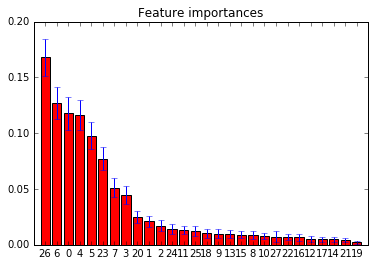

In [145]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(test_dataset.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_dataset.shape[1]), indices)
plt.xlim([-1, test_dataset.shape[1]])
plt.show()

### Naive Bayes

In [148]:
clf_gnb = GaussianNB()
clf_gnb.fit(train_dataset, train_labels)

GaussianNB(priors=None)

In [149]:
y_predict_gnb = clf_rf_cvv.predict(test_dataset)

In [150]:
np.mean(test_labels==y_predict_gnb)

0.85618006103763988

In [151]:
confusion_matrix(test_labels,y_predict_gnb)

array([[6733,    0],
       [1131,    0]])

### SVM - RBF

In [154]:
clf_svm_rbf = svm.SVC(probability=True,kernel='rbf')
%timeit clf_svm_rbf.fit(train_dataset, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [155]:
y_predict_rbf = clf_svm_rbf.predict(test_dataset)

In [156]:
np.mean(test_labels==y_predict_rbf)

0.85618006103763988

In [157]:
confusion_matrix(test_labels,y_predict_rbf)

array([[6733,    0],
       [1131,    0]])

### SVM - Linear

In [160]:
clf_svm_li = svm.SVC(probability=True,kernel='linear')


In [ ]:
%timeit clf_svm_li.fit(train_dataset, train_labels)

In [ ]:
y_predict_svml = clf_svm_li.predict(test_dataset)

In [ ]:
np.mean(test_labels==y_predict_svml)

In [ ]:
confusion_matrix(test_labels,y_predict_svml)